In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display, clear_output

# Spatial domain in millimetres for plotting/fit evaluation
z_min = -50                         # lower bound of z-grid [mm]
z_max = 30                          # upper bound of z-grid [mm]
z_values = np.linspace(z_min, z_max, 1000)   # dense grid for smooth curves

# Reference offset along z (homogenisation reference), stored in metres
Homo_offset = 31.5e-3               # 31.5 mm expressed in SI units (m)

# Plotting bounds for magnetic field magnitude (Gauss)
B_min = -400
B_max = 10

# Convert z grid to metres for polynomial models defined in SI
poly_values = z_values / 1000.0     # mm → m scaling to match coefficient units


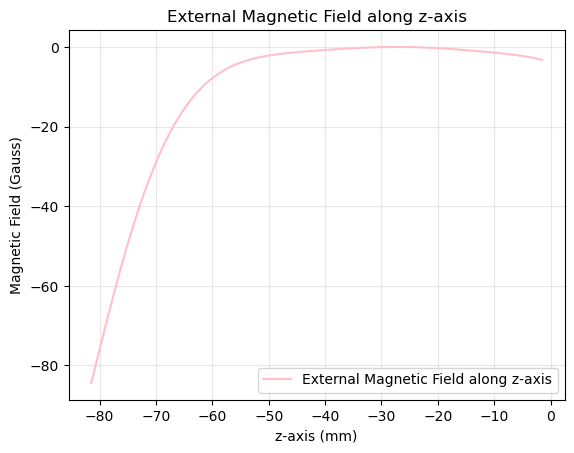

In [3]:
# Coefficients for external field model B(z) in Gauss; z is in metres
Intercept = -0.05859
B1 = 47.66114
B2 = -4865.06371
B3 = -146097.83504
B4 = 4260040.3748
B5 = 3.04437e8
B6 = -8.75637e9
B7 = -7.65903e10
B8 = 1.46997e12

# Evaluate 8th-order polynomial using vectorised operations for speed
B_external = (Intercept
              + B1 * poly_values**1
              + B2 * poly_values**2
              + B3 * poly_values**3
              + B4 * poly_values**4
              + B5 * poly_values**5
              + B6 * poly_values**6
              + B7 * poly_values**7
              + B8 * poly_values**8)

# Plot external field versus z, recentered by Homo_offset (converted back to mm)
plt.figure(1)
plt.plot(z_values - (Homo_offset * 1000.0),   # x-axis shift in mm for reference alignment
         B_external,
         label='External Magnetic Field along z-axis',
         color='pink')
plt.xlabel('z-axis (mm)')
plt.ylabel('Magnetic Field (Gauss)')
plt.title('External Magnetic Field along z-axis')
plt.grid(True, alpha=0.3)           # light grid aids visual comparison
plt.legend()
plt.show()


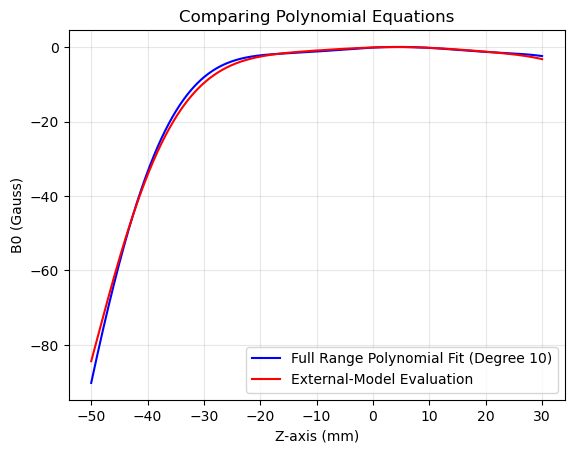

In [4]:
# Experimental calibration points (z in mm, B0 in Gauss)
points = [(-72, -300), (-64, -200), (-60, -165), (-51, -100), (-45, -55),
          (-40, -35), (-35, -17), (-25, -4), (-20, -2), (0, 0), (4.5, 0)]

# Split tuples into coordinate arrays for convenience
z_points, B0_values = zip(*points)

# Mirror data about the last x-point to extend coverage symmetrically (simple augmentation)
mirrored_points = [(2 * points[-1][0] - x, y) for x, y in points]

# Extract mirrored coordinates
mirrored_z_points, mirrored_B0_values = zip(*mirrored_points)

# Combine original and mirrored sets for a broader fit basis
all_points = points + mirrored_points
all_z_points, all_B0_values = zip(*all_points)

# Global polynomial degree for least-squares fit (trade-off: flexibility vs. overfit)
degree = 10

# Fit polynomial coefficients in the least-squares sense
coefficients = np.polyfit(all_z_points, all_B0_values, degree)

# Construct callable polynomial model B0_fit(z) with the fitted coefficients
poly_function = np.poly1d(coefficients)

# Generate a smooth mm-grid over [z_min, z_max] to compare fitted model to external poly
z_fit = np.linspace(z_min, z_max, 1000)
B0_fit = poly_function(z_fit)

# Compare fitted polynomial (mm domain) with external model (converted mm domain)
plt.subplot(1, 1, 1)
plt.title('Comparing Polynomial Equations')
plt.xlabel('Z-axis (mm)')
plt.ylabel('B0 (Gauss)')
plt.plot(z_fit, B0_fit,
         label=f'Full Range Polynomial Fit (Degree {degree})',
         color='blue')
plt.plot(z_values, B_external,
         label='External-Model Evaluation',
         color='red')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


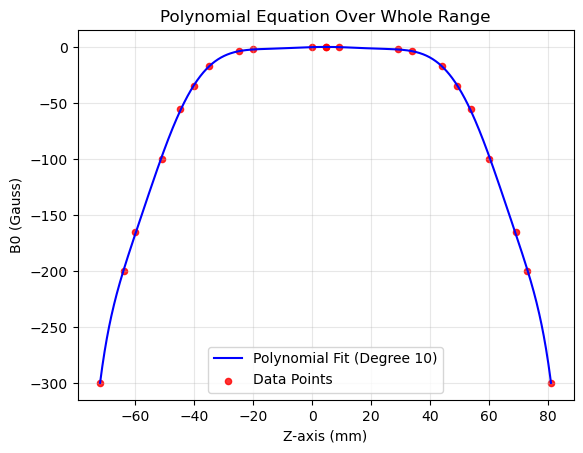

In [5]:
# Wider mm-domain to visualise extrapolation behaviour of the fit
z_fit = np.linspace(-72, 81, 1000)      # covers data and mirrored extension
B0_fit = poly_function(z_fit)           # evaluate fitted polynomial on the grid

# Visualise fit quality and dispersion relative to observed points
plt.subplot(1, 1, 1)
plt.title('Polynomial Equation Over Whole Range')
plt.xlabel('Z-axis (mm)')
plt.ylabel('B0 (Gauss)')
plt.plot(z_fit, B0_fit,
         label=f'Polynomial Fit (Degree {degree})',
         color='blue')
plt.scatter(all_z_points, all_B0_values,
            label='Data Points',
            color='red', s=20, alpha=0.8)  # show calibration points prominently
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


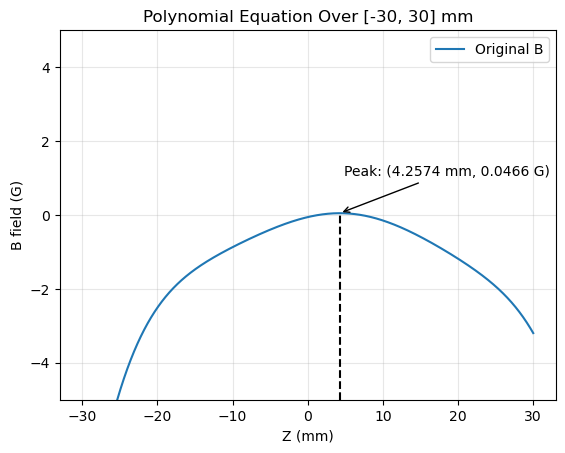

In [6]:
# High-resolution SI-domain near the centre for accurate extremum localisation
x = np.linspace(-30e-3, 30e-3, 10000)   # metres; dense sampling for robust argmax

# Evaluate external model on the SI grid (kept identical to earlier model definition)
B_original = (Intercept
              + B1 * x**1
              + B2 * x**2
              + B3 * x**3
              + B4 * x**4
              + B5 * x**5
              + B6 * x**6
              + B7 * x**7
              + B8 * x**8)

# Create figure/axes up front for explicit control of limits and annotations
fig, ax = plt.subplots(1, 1)
ax.plot(x * 1e3, B_original, label='Original B')    # convert x from m to mm for the x-axis

# Tight y-window highlights local behaviour near zero crossing/peak
ax.set_ylim(-5, 5)
ax.set_xlabel('Z (mm)')
ax.set_ylabel('B field (G)')

# Locate the maximum over the sampled interval (argmax is index-based and vectorised)
peak_index = np.argmax(B_original)
peak_x = x[peak_index] * 1e3          # convert peak location to mm for display
peak_y = B_original[peak_index]

# Draw a reference line at the detected peak position
ax.plot([peak_x, peak_x], [ax.get_ylim()[0], peak_y], 'k--')

# Title and precise annotation to document the extremum
plt.title('Polynomial Equation Over [-30, 30] mm')
ax.annotate(f'Peak: ({peak_x:.4f} mm, {peak_y:.4f} G)',
            xy=(peak_x, peak_y),
            xytext=(peak_x + 0.5, peak_y + 1.0),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

ax.legend()
plt.grid(True, alpha=0.3)
plt.show()
